# Aula 3_4 - BERT

Nome:

## Instruções:


Criar um modelo de linguagem e medir a perplexidade utilizando o dataset do Machado de Assis, utilizando Embeddings gerados por um BERT pré-treinado e uma MLP.

- Deve-se implementar o próprio laço de treinamento. **Não usar frameworks de treinamento automático.**
- Utilizar o BertModel.from_pretrained e BertTokenizer.from_pretrained do Hugging Face para carregar o BERT pré-treinado.
- Não utilize outras classes da HuggingFace/Transformers alem da [BertModel](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel) e [BertTokenizer](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertTokenizer).
- Trabalhe no espaço dos tokens/inteiros. Uma forma de fazer isso é tokenizar o dataset inteiro como pré-processamento.
- Experimente com aumentar o contexto e congelar ou não os parâmetros do BERT. Cuidado que o contexto é o maior fator para o peso computacional aqui.
- Sugerimos utilizar um BERT treinado em português como o BerTimbau: "neuralmind/bert-base-portuguese-cased".
- Inicialmente utilizar o hidden_state do token CLS. Podem experimentar com outras formas de usar o last_hidden_state.
- MLP deve utilizar o vocab_size do BERT na saída. Isso gera um grande desafio de manter o tamanho da MLP razoável.
- Deixe para usar GPU somente quando tudo estiver validado em parte pequena do dataset. Uma época pode demorar 30 minutos ou mais no dataset inteiro.

Opcional:
- Utilize bfloat16 para economizar memória da GPU.

In [38]:
from transformers import BertModel, BertTokenizer
from collections import Counter
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import numpy as np
import random
import os
import re

from typing import Sequence
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader

from transformers import BertModel
import time

import torch.optim as optim

In [39]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dados

Vamos usar o mesmo dataset do Machado de Assis.



In [40]:
!git clone https://github.com/ethelbeluzzi/projetomachado

fatal: destination path 'projetomachado' already exists and is not an empty directory.


In [41]:
DATA_PATH = os.path.join("projetomachado", "textonormalizado1000.txt")

In [42]:
def read_corpus(path: str) -> Sequence[str]:
    """
    Lê um arquivo de texto e retorna uma lista de parágrafos.
    """

    # Abre o arquivo e lê suas linhas, removendo espaços em branco e linhas vazias
    with open(path, "r") as data_file:
        data_text = [line.strip() for line in data_file if line.strip()]

    corpus = []  # Lista para armazenar os parágrafos processados
    current_paragraph = ""  # String que acumula as linhas até formar um parágrafo completo

    # Itera sobre as linhas do texto
    for i, line in enumerate(data_text):
        # Verifica se a linha termina com pontuação indicando o fim de uma frase
        if line[-1] in (".", "!", "?"):
            # Se sim, adiciona a linha ao parágrafo atual e finaliza o parágrafo
            current_paragraph += line
            corpus.append(current_paragraph)  # Armazena o parágrafo completo na lista corpus
            current_paragraph = ""  # Reinicia para começar um novo parágrafo
        else:
            # Caso contrário, continua acumulando a linha no parágrafo atual
            current_paragraph += f"{line} "

    # Adiciona o último parágrafo, caso não tenha sido finalizado dentro do loop
    if current_paragraph:
        corpus.append(current_paragraph.strip())  # Remove espaços extras antes de adicionar

    return corpus, data_text  # Retorna a lista de parágrafos e as linhas do arquivo

def text_statistics(data_text: Sequence[str]):
    """
    Calcula e imprime o número total de linhas, palavras e caracteres.
    """
    total_lines = len(data_text)
    total_words = sum(len(line.split()) for line in data_text)
    total_characters = sum(len(line) for line in data_text)

    print(f"Total de linhas: {total_lines}")
    print(f"Total de palavras: {total_words}")
    print(f"Total de caracteres: {total_characters}\n")

# Chama a função e exibe as estatísticas
corpus, data_text = read_corpus(DATA_PATH)
text_statistics(data_text)

# É possível voltar a um texto monolítico juntando as linhas.
full_data = ' '.join(data_text)
full_data[:1000]

Total de linhas: 305276
Total de palavras: 3289646
Total de caracteres: 18539036



'1 MINISTÉRIO DA CULTURA Fundação Biblioteca Nacional Departamento Nacional do Livro A MÃO E A LUVA Machado de Assis I O fim da carta Mas que pretendes fazer agora? Morrer. Morrer? Que idéia! Deixate disso, Estêvão. Não se morre por tão pouco... Morrese. Quem não padece estas dores não as pode avaliar. O golpe foi profundo, e o meu coração é pusilânime; por mais aborrecível que pareça a idéia da morte, pior, muito pior do que ela, é a de viver. Ah! tu não sabes o que isto é? Sei: um namoro gorado... Luís! ... E se em cada caso de namoro gorado morresse um homem, tinha já diminuído muito o gênero humano, e Malthus perderia o latim. Anda, sobe. Estêvão meteu a mão nos cabelos com um gesto de angústia; Luís Alves sacudiu a cabeça e sorriu. Achavamse os dois no corredor da casa de Luís Alves, à rua da Constituição,  que então se chamava dos Ciganos;  então, isto é, em 1853, uma bagatela de vinte anos que lá vão, levando talvez consigo as ilusões do leitor, e deixandolhe em troca usurários!

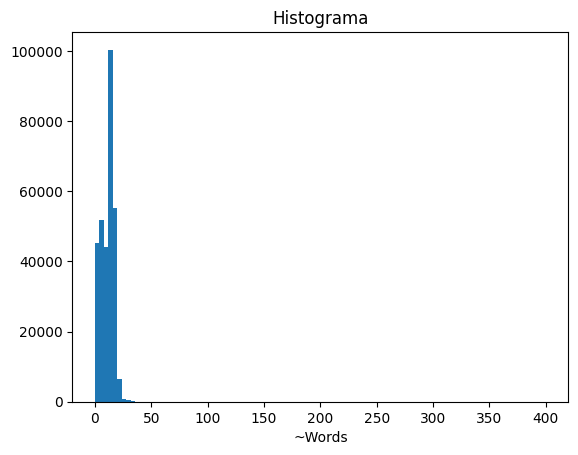

In [43]:
# Check data distribution
line_lens = [len(line.split()) for line in data_text]
plt.title("Histograma")
plt.hist(line_lens, bins=100, range=(0, 400))
plt.xlabel("~Words")
plt.show()

In [44]:
# Separar em treino e teste
limit = int(0.8*len(full_data))
train_data = full_data[:limit]
val_data = full_data[limit:]

# Não utilize o split val para nada a partir daqui, somente validar
len(train_data), len(val_data)

(15075448, 3768863)

## Tokenizer
-Testar com strings\
-Tokens especiais\
-Tokenize\
-Decode\
-Batch e padding


In [45]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [46]:
# Certifique-se de que 'total_lines' está definido e contém os dados que você deseja fatiar.
# Por exemplo, se 'full_data' contiver os dados com os quais você deseja trabalhar, use a linha abaixo:
total_lines = full_data[:1000]

# Se você pretende usar uma variável diferente, substitua 'full_data' pelo nome correto da variável.

In [47]:
# Definindo o tamanho do contexto: 5 palavras de entrada. O target é a próxima palavra
context_size = 5

class MachadoDataset(Dataset):
    def __init__(self, text, context_size, tokenizer):
        self.context_size = context_size

        mono_words = []
        inputs = []
        output = []

        # Processa cada linha do texto e extrai palavras
        for line in text:
            words = self.split_text(line)
            mono_words.extend(words)

        # Cria janelas deslizantes de palavras para gerar entradas e saídas
        for i in range(len(mono_words) - context_size):
            data = mono_words[i:i + context_size + 1]
            target_word = data[-1]

            # Verifica se a palavra alvo é composta por apenas um token
            if len(tokenizer.tokenize(target_word)) != 1:
                continue

            inputs.append(' '.join(data[:-1]))  # Palavras de entrada
            output.append(target_word)  # Próxima palavra como saída

        # Tokeniza os dados de entrada
        tokenized_inputs = tokenizer(inputs, return_tensors='pt',
                                     max_length=context_size + 5,  # sos + eos + 3
                                     padding='max_length', truncation=True)
        self.source = tokenized_inputs.input_ids
        self.mask = tokenized_inputs.attention_mask
        self.target = tokenizer(output, return_tensors='pt').input_ids[:, 1]  # Ignora o token de início

    @staticmethod
    def split_text(text):
        # Separa o texto em palavras e pontuações
        return re.findall(r'\w+|[.,]', text)

    def __len__(self):
        # Retorna o número total de amostras no dataset
        return len(self.target)

    def __getitem__(self, idx):
        # Retorna uma amostra do dataset no índice especificado
        src = {'src': self.source[idx], 'mask': self.mask[idx]}
        return src, self.target[idx]

# Exemplo de uso do MachadoDataset
my_dataset = MachadoDataset(total_lines, context_size, tokenizer)
sample = my_dataset[0]

print(f'Length of Dataset: {len(my_dataset)}')
print('==> Sample <==')
print(f'Source: {sample[0]}')
print(f'Target: {sample[1]}')


Length of Dataset: 799
==> Sample <==
Source: {'src': tensor([ 101, 1015, 1049, 1045, 1050, 1045,  102,    0,    0,    0]), 'mask': tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0])}
Target: 1055


In [48]:
# Definindo a proporção de divisão (80% treino, 20% validação)
train_ratio = 0.8
validation_ratio = 1 - train_ratio

# Calculando os tamanhos dos datasets de treino e validação
total_size = len(my_dataset)
train_size = int(train_ratio * total_size)
validation_size = total_size - train_size

# Garantir que a divisão seja reprodutível com random_state=18
generator = torch.Generator().manual_seed(18)

# Dividindo o dataset em treino e validação
train_dataset, validation_dataset = random_split(my_dataset,
                                                 [train_size, validation_size],
                                                 generator=generator)

print(f'Tamanho do Dataset de Treino: {len(train_dataset)}')
print(f'Tamanho do Dataset de Validação: {len(validation_dataset)}')


Tamanho do Dataset de Treino: 639
Tamanho do Dataset de Validação: 160


In [49]:
# Definição do tamanho do lote
batch_size = 128

# Criação dos DataLoaders para os datasets de treino e validação
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

# Obtém um lote de exemplos do DataLoader de treino
sample = next(iter(train_loader))

# Exibe as dimensões dos tensores de entrada (source) e saída (target)
print(f'Shape of source: {sample[0]["src"].shape}')
print(f'Shape of target: {sample[1].shape}')


Shape of source: torch.Size([128, 10])
Shape of target: torch.Size([128])


## Modelo

In [50]:
!pip install torchinfo -q

In [51]:
import torchinfo
from transformers import BertModel

class LanguageModel(nn.Module):
    """
    Modelo de linguagem baseado no BERT com uma MLP para predição da próxima palavra.
    """
    def __init__(self, ff_hidden_layer):
        """
        Inicializa o modelo BERT e as camadas lineares para predição.

        Args:
            ff_hidden_layer (int): Número de neurônios na camada oculta da MLP.
        """
        super(LanguageModel, self).__init__()
        # Carrega o modelo BERT pré-treinado
        self.bert = BertModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

        # Inicializa as camadas lineares
        self.fc1 = nn.Linear(self.bert.config.hidden_size, ff_hidden_layer)
        self.fc2 = nn.Linear(ff_hidden_layer, self.bert.config.vocab_size)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        """
        Define a passagem direta pelo modelo.

        Args:
            input_ids (Tensor): IDs dos tokens de entrada.
            attention_mask (Tensor, opcional): Máscara de atenção.
            token_type_ids (Tensor, opcional): IDs dos tipos de token.

        Returns:
            Tensor: Logits preditos para cada token do vocabulário.
        """
        # Passa os dados pelo BERT
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        # Usa a saída do token [CLS]
        cls_output = outputs.pooler_output

        # Passa pela MLP
        x = F.relu(self.fc1(cls_output))
        logits = self.fc2(x)

        return logits

# Definir hiperparâmetros
hidden_size = 600  # Número de neurônios na camada oculta

# Instanciar o modelo
model = LanguageModel(hidden_size)

# Convertendo os parâmetros do modelo para uma lista
params = list(model.named_parameters())

# Imprimindo os parâmetros das duas últimas camadas
for name, param in params[-4:]:
    print(f"Layer: {name} | Size: {list(param.size())}")

# Contando o número total de parâmetros
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal number of parameters: {total_params}")


Layer: fc1.weight | Size: [600, 768]
Layer: fc1.bias | Size: [600]
Layer: fc2.weight | Size: [29794, 600]
Layer: fc2.bias | Size: [29794]

Total number of parameters: 127290730


In [52]:
tokenizer("aborrecível que pareça a idéia", return_tensors='pt').input_ids

tensor([[  101, 11113,  2953,  2890,  6895, 15985, 10861, 11968, 19281,  1037,
          8909, 27958,   102]])

In [53]:
# O que esta dentro da classe?
torchinfo.summary(model,
                  input_data=tokenizer("aborrecível que pareça a idéia", return_tensors='pt').input_ids,
                  depth=3)

Layer (type:depth-idx)                                       Output Shape              Param #
LanguageModel                                                [1, 29794]                --
├─BertModel: 1-1                                             [1, 768]                  --
│    └─BertEmbeddings: 2-1                                   [1, 13, 768]              --
│    │    └─Embedding: 3-1                                   [1, 13, 768]              22,881,792
│    │    └─Embedding: 3-2                                   [1, 13, 768]              1,536
│    │    └─Embedding: 3-3                                   [1, 13, 768]              393,216
│    │    └─LayerNorm: 3-4                                   [1, 13, 768]              1,536
│    │    └─Dropout: 3-5                                     [1, 13, 768]              --
│    └─BertEncoder: 2-2                                      [1, 13, 768]              --
│    │    └─ModuleList: 3-6                                  --             

In [54]:
# Obter um lote de amostras do DataLoader de treino
sample = next(iter(train_loader))

# Passagem para frente (Forward pass)
output = model(sample[0]['src'], sample[0]['mask'])

# Exibir a forma da saída do modelo
print(f'Shape of output: {output.shape}')

# Exibir o tamanho do vocabulário do modelo BERT
print(f'Vocab size: {model.bert.config.vocab_size}')

# Exibir o tamanho do vocabulário do tokenizer
print(f'Tokenizer vocab size: {tokenizer.vocab_size}')


Shape of output: torch.Size([128, 29794])
Vocab size: 29794
Tokenizer vocab size: 30522


## Classe do dataset

Utilize o Tokenizer do Bert na classe Dataset.
Defina um tamanho de sequencia/contexto.

In [55]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Initial Validation Loss: 10.2895, Initial Validation Accuracy: 0.00%, Initial Perplexity: 29421.84
Epoch [1/5], Train loss:10.0595, Train acc:4.69%, Test loss:9.6876, Test acc: 10.00%, Perplexity:16116.97, Elapsed Time: 31.78 sec
Epoch [2/5], Train loss:9.2701, Train acc:15.18%, Test loss:8.6656, Test acc: 11.88%, Perplexity:5799.99, Elapsed Time: 32.43 sec
Epoch [3/5], Train loss:7.8851, Train acc:14.08%, Test loss:6.9465, Test acc: 13.12%, Perplexity:1039.51, Elapsed Time: 30.13 sec
Epoch [4/5], Train loss:5.7314, Train acc:15.65%, Test loss:4.7338, Test acc: 10.62%, Perplexity:113.72, Elapsed Time: 30.38 sec
Epoch [5/5], Train loss:3.8956, Train acc:14.08%, Test loss:3.7421, Test acc: 10.62%, Perplexity:42.18, Elapsed Time: 30.62 sec


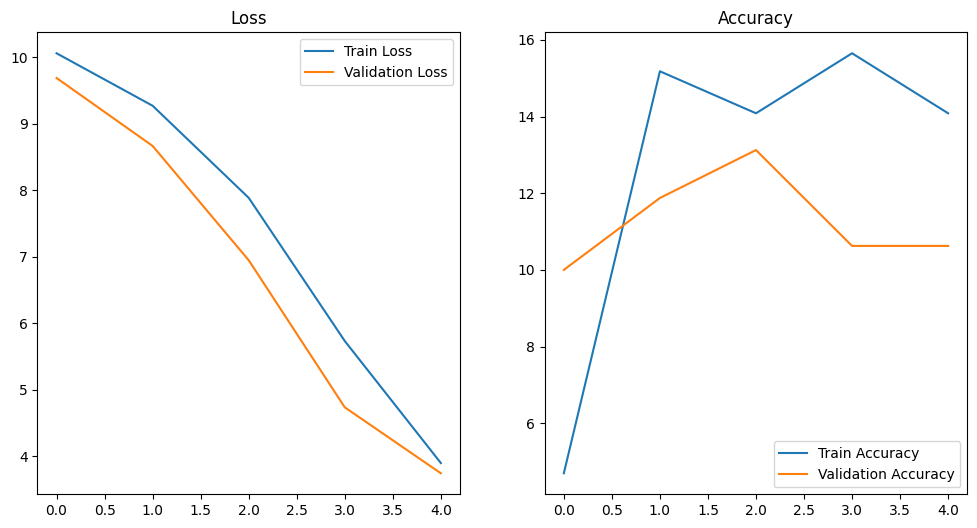

In [69]:
# Definição do modelo LanguageModel (supondo que já esteja implementado)
class LanguageModel(nn.Module):
    def __init__(self, ff_hidden_layer):
        super(LanguageModel, self).__init__()
        self.bert = BertModel.from_pretrained('neuralmind/bert-base-portuguese-cased')
        self.fc1 = nn.Linear(self.bert.config.hidden_size, ff_hidden_layer)
        self.fc2 = nn.Linear(ff_hidden_layer, self.bert.config.vocab_size)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_output = outputs.pooler_output
        x = F.relu(self.fc1(cls_output))
        logits = self.fc2(x)
        return logits

# Definição da classe TrainHelper
class TrainHelper:
    """
    Classe auxiliar para o treinamento e validação de modelos.
    """
    def __init__(self, model: nn.Module, device):
        self.model = model.to(device)
        self.device = device

    def train_epoch(self, data_loader: torch.utils.data.DataLoader, criterion, optimizer) -> float:
        """
        Executa uma época de treinamento.
        """
        self.model.train()
        total_loss = 0.0
        total_acc = 0.0
        total_samples = 0

        for inputs, targets in data_loader:
            inputs = {key: value.to(self.device) for key, value in inputs.items()}
            targets = targets.to(self.device)
            optimizer.zero_grad()

            logits = self.model(inputs['src'], inputs['mask'])
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * targets.size(0)
            preds = logits.argmax(dim=1)
            total_acc += (preds == targets).sum().item()
            total_samples += targets.size(0)

        avg_loss = total_loss / total_samples
        avg_acc = total_acc / total_samples * 100

        return avg_loss, avg_acc

    def validate(self, data_loader: torch.utils.data.DataLoader, criterion) -> float:
        """
        Executa a validação do modelo.
        """
        self.model.eval()
        total_loss = 0.0
        total_acc = 0.0
        total_samples = 0

        with torch.no_grad():
            for inputs, targets in data_loader:
                inputs = {key: value.to(self.device) for key, value in inputs.items()}
                targets = targets.to(self.device)

                logits = self.model(inputs['src'], inputs['mask'])
                loss = criterion(logits, targets)

                total_loss += loss.item() * targets.size(0)
                preds = logits.argmax(dim=1)
                total_acc += (preds == targets).sum().item()
                total_samples += targets.size(0)

        avg_loss = total_loss / total_samples
        avg_acc = total_acc / total_samples * 100

        return avg_loss, avg_acc

# Hiperparâmetros
epochs = 5
lr = 5e-4
hidden_size = 600

# Instancia o modelo e move para o dispositivo adequado
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LanguageModel(hidden_size).to(device)

# Congela todos os parâmetros do modelo
for param in model.parameters():
    param.requires_grad = False

# Descongela os parâmetros das últimas camadas lineares
for param in model.fc1.parameters():
    param.requires_grad = True
for param in model.fc2.parameters():
    param.requires_grad = True

# Configuração da função de perda e do otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

# Cria um objeto TrainHelper para facilitar o treinamento e a validação
helper = TrainHelper(model, device)

# Inicializa as listas de perdas e métricas
history = {
    'train_loss': [],
    'eval_loss': [],
    'train_acc': [],
    'eval_acc': []
}

# Cálculo da perplexidade inicial
initial_val_loss, initial_val_acc = helper.validate(val_loader, criterion)
initial_perplexity = torch.exp(torch.tensor(initial_val_loss))
print(f'Initial Validation Loss: {initial_val_loss:.4f}, Initial Validation Accuracy: {initial_val_acc:.2f}%, '
      f'Initial Perplexity: {initial_perplexity:.2f}')

# Loop de treinamento
for epoch in range(epochs):
    start_time_epoch = time.time()  # Início da época

    # Treinamento para uma época
    train_loss, train_acc = helper.train_epoch(train_loader, criterion, optimizer)

    # Avaliação após a época de treinamento
    val_loss, val_acc = helper.validate(val_loader, criterion)

    epoch_duration = time.time() - start_time_epoch  # Duração da época

    # Armazenamento das métricas
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['eval_loss'].append(val_loss)
    history['eval_acc'].append(val_acc)

    # Cálculo da perplexidade
    perplexity = torch.exp(torch.tensor(val_loss))

    # Impressão dos resultados da época
    print(f'Epoch [{epoch+1}/{epochs}], Train loss:{train_loss:.4f}, Train acc:{train_acc:.2f}%, '
          f'Test loss:{val_loss:.4f}, Test acc: {val_acc:.2f}%, '
          f'Perplexity:{perplexity:.2f}, Elapsed Time: {epoch_duration:.2f} sec')

# Plotagem das curvas de perda e perplexidade
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(len(history['train_loss'])), history['train_loss'], label="Train Loss")
plt.plot(range(len(history['eval_loss'])), history['eval_loss'], label="Validation Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(history['train_acc'])), history['train_acc'], label="Train Accuracy")
plt.plot(range(len(history['eval_acc'])), history['eval_acc'], label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()

plt.show()


## Exemplo de uso

In [71]:
class NextWord(nn.Module):
    """
    Classe para gerar a próxima palavra usando um modelo de linguagem.
    """
    def __init__(self, language_model, context_size, tokenizer):
        super(NextWord, self).__init__()
        self.model = language_model
        self.context_size = context_size
        self.tokenizer = tokenizer

    def __call__(self, text, max_length):
        """
        Gera texto até atingir o comprimento máximo especificado.

        Args:
            text (str): Texto de entrada para começar a geração.
            max_length (int): Comprimento máximo do texto gerado.

        Returns:
            str: Texto gerado.
        """
        # Codifica o texto de entrada em tensores
        input_ids = self.tokenizer.encode(text, return_tensors='pt')
        input_ids = input_ids[:, 1:-1].to(device)  # Remove os tokens [SOS] e [EOS]

        self.model.eval()  # Coloca o modelo em modo de avaliação
        print('Output:', end=' ')

        for step in range(input_ids.size(1), max_length):
            # Obtém o contexto (últimos context_size tokens)
            start_idx = max(0, step - self.context_size)
            context = input_ids[:, start_idx:step]

            # Adiciona os tokens [SOS] e [EOS] ao contexto
            context = torch.cat((torch.tensor([[101]], device=device),  # [SOS]
                                 context,
                                 torch.tensor([[102]], device=device)), dim=1)  # [EOS]

            # Gera logits para o contexto atual
            logits = self.model(context)
            next_token_id = logits.argmax(dim=1).unsqueeze(0)  # Obtém o token mais provável

            print(next_token_id.squeeze(0).tolist(), end=' ')  # Imprime o token gerado
            input_ids = torch.cat((input_ids, next_token_id), dim=1)  # Adiciona o token gerado à entrada

        # Decodifica o texto gerado e retorna
        output_text = self.tokenizer.decode(input_ids.squeeze(0).tolist())
        print('\nGenerated Text:')
        return output_text

# Instancia a classe NextWord com o modelo de linguagem e tokenizer
next_word = NextWord(model, context_size, tokenizer)

# Teste de geração de texto
print(f'\nTeste\n')
text = "Estêvão meteu a mão"
max_length = 30
generated_text = next_word(text, max_length)
print(generated_text)



Teste

Output: [1041] [1041] [1041] [1037] [1037] [1041] [1041] [1041] [1041] [1041] [1037] [1037] [1041] [1041] [1041] [1041] [1041] [1037] [1037] [1041] [1041] [1041] [1041] [1041] 
Generated Text:
estevao meteu a mao e e e a a e e e e e a a e e e e e a a e e e e e
